# Setup

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.utils._testing import ignore_warnings
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

SEED = 15

# Data

In [3]:
df = pd.read_csv('../data/dementia_patients_health_data.csv')
df.head()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,...,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,NaN,NaN,60,...,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,Galantamine,12.0,61,...,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,NaN,NaN,69,...,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,Donepezil,23.0,78,...,Never Smoked,Negative,Mild Activity,Yes,5,Yes,Balanced Diet,Poor,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,Memantine,20.0,77,...,Never Smoked,Positive,Mild Activity,No,0,Yes,Low-Carb Diet,Good,Diabetes,1


## Data preprocessing

### Features relationship matrix

In [4]:
df.describe()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Dosage in mg,Age,Cognitive_Test_Scores,Dementia
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,485.000000,1000.000000,1000.000000,1000.000000
mean,0.513000,0.098429,79.383000,95.226051,36.761513,74.321326,30.103568,9.213402,74.908000,6.383000,0.485000
std,0.500081,0.058715,12.107556,2.929262,0.431701,14.463765,16.862170,6.493188,9.095068,3.180633,0.500025
min,0.000000,0.000414,60.000000,90.010677,36.002108,50.069731,0.094684,1.500000,60.000000,0.000000,0.000000
25%,0.000000,0.045505,68.000000,92.875017,36.395363,61.387339,16.237371,4.000000,67.000000,4.000000,0.000000
50%,1.000000,0.098235,79.000000,95.390420,36.784319,74.149204,29.577194,8.000000,75.000000,8.000000,0.000000
75%,1.000000,0.151840,90.000000,97.785111,37.126655,87.024034,44.176723,12.000000,83.000000,9.000000,1.000000
max,1.000000,0.199866,100.000000,99.999230,37.496809,99.982722,59.957599,23.000000,90.000000,10.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Diabetic                   1000 non-null   int64  
 1   AlcoholLevel               1000 non-null   float64
 2   HeartRate                  1000 non-null   int64  
 3   BloodOxygenLevel           1000 non-null   float64
 4   BodyTemperature            1000 non-null   float64
 5   Weight                     1000 non-null   float64
 6   MRI_Delay                  1000 non-null   float64
 7   Prescription               485 non-null    object 
 8   Dosage in mg               485 non-null    float64
 9   Age                        1000 non-null   int64  
 10  Education_Level            1000 non-null   object 
 11  Dominant_Hand              1000 non-null   object 
 12  Gender                     1000 non-null   object 
 13  Family_History             1000 non-null   object

### Filling columns

In [6]:
df['Dosage in mg'] = df['Dosage in mg'].fillna(0)
df['Prescription'] = df['Prescription'].fillna('No Prescription').astype('category')

### Converting object columns to categorical

In [7]:
columns = ['Education_Level', 'Dominant_Hand', 'Gender', 'Family_History', 'Smoking_Status', 'APOE_ε4', 'Physical_Activity', 'Depression_Status', 'Medication_History', 'Nutrition_Diet', 'Sleep_Quality', 'Chronic_Health_Conditions']

df[columns] = df[columns].astype('category')

### Converting continuous to categorical

In [8]:
df['AgeBand'] = pd.qcut(df.Age, 6)
df[['AgeBand', 'Dementia']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='Dementia', ascending=True)

C:\Users\phoso\AppData\Local\Temp\ipykernel_17388\4177405561.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['AgeBand', 'Dementia']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='Dementia', ascending=True)


,AgeBand,Dementia
4,"(80.0, 85.0]",0.437126
3,"(75.0, 80.0]",0.448980
1,"(65.0, 70.0]",0.465517
5,"(85.0, 90.0]",0.481928
2,"(70.0, 75.0]",0.503268
0,"(59.999, 65.0]",0.559585


In [9]:
df.loc[ df.Age <= 65, 'Age' ] = 0
df.loc[ (df.Age > 65) & (df.Age <= 70), 'Age' ] = 1
df.loc[ (df.Age > 70) & (df.Age <= 75), 'Age' ] = 2
df.loc[ (df.Age > 75) & (df.Age <= 80), 'Age' ] = 3
df.loc[ (df.Age > 80) & (df.Age <= 85), 'Age' ] = 4
df.loc[ (df.Age > 85) & (df.Age <= 90), 'Age' ] = 5
df.Age = df.Age.astype(int)

df.drop(['AgeBand'], axis=1, inplace=True)

df.head(3)

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,...,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,No Prescription,0.0,0,...,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,Galantamine,12.0,0,...,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,No Prescription,0.0,1,...,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0


In [10]:
df['HeartRateBand'] = pd.qcut(df.HeartRate, 5)
df[['HeartRateBand', 'Dementia']].groupby(['HeartRateBand'], as_index=False).mean().sort_values(by='Dementia', ascending=True)

C:\Users\phoso\AppData\Local\Temp\ipykernel_17388\3364113139.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['HeartRateBand', 'Dementia']].groupby(['HeartRateBand'], as_index=False).mean().sort_values(by='Dementia', ascending=True)


,HeartRateBand,Dementia
1,"(67.0, 75.0]",0.459184
4,"(92.0, 100.0]",0.463542
2,"(75.0, 83.4]",0.463687
0,"(59.999, 67.0]",0.493333
3,"(83.4, 92.0]",0.538462


In [11]:
df.loc[ df.HeartRate <= 67, 'HeartRate' ] = 0
df.loc[ (df.HeartRate > 67) & (df.HeartRate <= 75), 'HeartRate' ] = 1
df.loc[ (df.HeartRate > 75) & (df.HeartRate <= 83.4), 'HeartRate' ] = 2
df.loc[ (df.HeartRate > 83.4) & (df.HeartRate <= 92), 'HeartRate' ] = 3
df.loc[ df.HeartRate > 92, 'HeartRate' ] = 4
df.HeartRate = df.HeartRate.astype(int)

df.drop(['HeartRateBand'], axis=1, inplace=True)

df.head(3)

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,...,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,4,96.230743,36.224852,57.563978,36.421028,No Prescription,0.0,0,...,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,2,93.032122,36.183874,56.832335,31.157633,Galantamine,12.0,0,...,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,3,93.566504,37.326321,59.759066,37.640435,No Prescription,0.0,1,...,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0


In [12]:
df['BodyTemperatureBand'] = pd.qcut(df.BodyTemperature, 5)
df[['BodyTemperatureBand', 'Dementia']].groupby(['BodyTemperatureBand'], as_index=False).mean().sort_values(by='Dementia', ascending=True)

C:\Users\phoso\AppData\Local\Temp\ipykernel_17388\1377460153.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['BodyTemperatureBand', 'Dementia']].groupby(['BodyTemperatureBand'], as_index=False).mean().sort_values(by='Dementia', ascending=True)


,BodyTemperatureBand,Dementia
0,"(36.001000000000005, 36.318]",0.430
1,"(36.318, 36.606]",0.460
4,"(37.208, 37.497]",0.475
3,"(36.931, 37.208]",0.505
2,"(36.606, 36.931]",0.555


In [13]:
df.loc[ df.BodyTemperature <= 36.318, 'BodyTemperature' ] = 0
df.loc[ (df.BodyTemperature > 36.318) & (df.BodyTemperature <= 36.606), 'BodyTemperature' ] = 1
df.loc[ (df.BodyTemperature > 36.606) & (df.BodyTemperature <= 36.931), 'BodyTemperature' ] = 2
df.loc[ (df.BodyTemperature > 36.931) & (df.BodyTemperature <= 37.208), 'BodyTemperature' ] = 3
df.loc[ df.BodyTemperature > 37.208, 'BodyTemperature' ] = 4
df.BodyTemperature = df.BodyTemperature.astype(int)

df.drop(['BodyTemperatureBand'], axis=1, inplace=True)

df.head(3)

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,...,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,4,96.230743,0,57.563978,36.421028,No Prescription,0.0,0,...,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,2,93.032122,0,56.832335,31.157633,Galantamine,12.0,0,...,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,3,93.566504,4,59.759066,37.640435,No Prescription,0.0,1,...,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0


In [14]:
df['WeightBand'] = pd.qcut(df.Weight, 5)
df[['WeightBand', 'Dementia']].groupby(['WeightBand'], as_index=False).mean().sort_values(by='Dementia', ascending=True)

C:\Users\phoso\AppData\Local\Temp\ipykernel_17388\3319646648.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['WeightBand', 'Dementia']].groupby(['WeightBand'], as_index=False).mean().sort_values(by='Dementia', ascending=True)


,WeightBand,Dementia
2,"(69.589, 79.644]",0.420
3,"(79.644, 89.241]",0.440
1,"(59.037, 69.589]",0.495
4,"(89.241, 99.983]",0.510
0,"(50.069, 59.037]",0.560


In [15]:
df.loc[ df.Weight <= 59, 'Weight' ] = 0
df.loc[ (df.Weight > 59) & (df.Weight <= 69.5), 'Weight' ] = 1
df.loc[ (df.Weight > 69.5) & (df.Weight <= 79.5), 'Weight' ] = 2
df.loc[ (df.Weight > 79.5) & (df.Weight <= 89), 'Weight' ] = 3
df.loc[ df.Weight > 89, 'Weight' ] = 4
df.Weight = df.Weight.astype(int)

df.drop(['WeightBand'], axis=1, inplace=True)

df.head(3)

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,...,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,4,96.230743,0,0,36.421028,No Prescription,0.0,0,...,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,2,93.032122,0,0,31.157633,Galantamine,12.0,0,...,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,3,93.566504,4,1,37.640435,No Prescription,0.0,1,...,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0


In [16]:
df['MRI_DelayBand'] = pd.qcut(df.MRI_Delay, 5)
df[['MRI_DelayBand', 'Dementia']].groupby(['MRI_DelayBand'], as_index=False).mean()

C:\Users\phoso\AppData\Local\Temp\ipykernel_17388\2742022208.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['MRI_DelayBand', 'Dementia']].groupby(['MRI_DelayBand'], as_index=False).mean()


,MRI_DelayBand,Dementia
0,"(0.0937, 13.116]",0.465
1,"(13.116, 24.44]",0.485
2,"(24.44, 35.093]",0.475
3,"(35.093, 47.264]",0.500
4,"(47.264, 59.958]",0.500


In [17]:
df.loc[ df.MRI_Delay <= 13, 'MRI_Delay' ] = 0
df.loc[ (df.MRI_Delay > 13) & (df.MRI_Delay <= 24.5), 'MRI_Delay' ] = 1
df.loc[ (df.MRI_Delay > 24.5) & (df.MRI_Delay <= 35), 'MRI_Delay' ] = 2
df.loc[ (df.MRI_Delay > 35) & (df.MRI_Delay <= 47), 'MRI_Delay' ] = 3
df.loc[ df.MRI_Delay > 47, 'MRI_Delay' ] = 4
df.MRI_Delay = df.MRI_Delay.astype(int)

df.drop(['MRI_DelayBand'], axis=1, inplace=True)

df.head(3)

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,...,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,4,96.230743,0,0,3,No Prescription,0.0,0,...,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,2,93.032122,0,0,2,Galantamine,12.0,0,...,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,3,93.566504,4,1,3,No Prescription,0.0,1,...,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0


### Columns to drop

#### Prescription, Dosage in mg & Cognitive_Test_Score
* As colunas 'Prescription' e 'Dosage in mg' são dados obtidos após o laudo médico de demência, sendo assim, devem ser retiradas a fim de evitar data_leak.
* A coluna 'Cognitive_Test_Score' provavelmente foi utilizada como um forte antecedente para o diagnóstico do paciente, sendo que todos os pacientes com nota inferior à 8 foram classificados como portadores da doença. Sendo assim, deve ser removida.

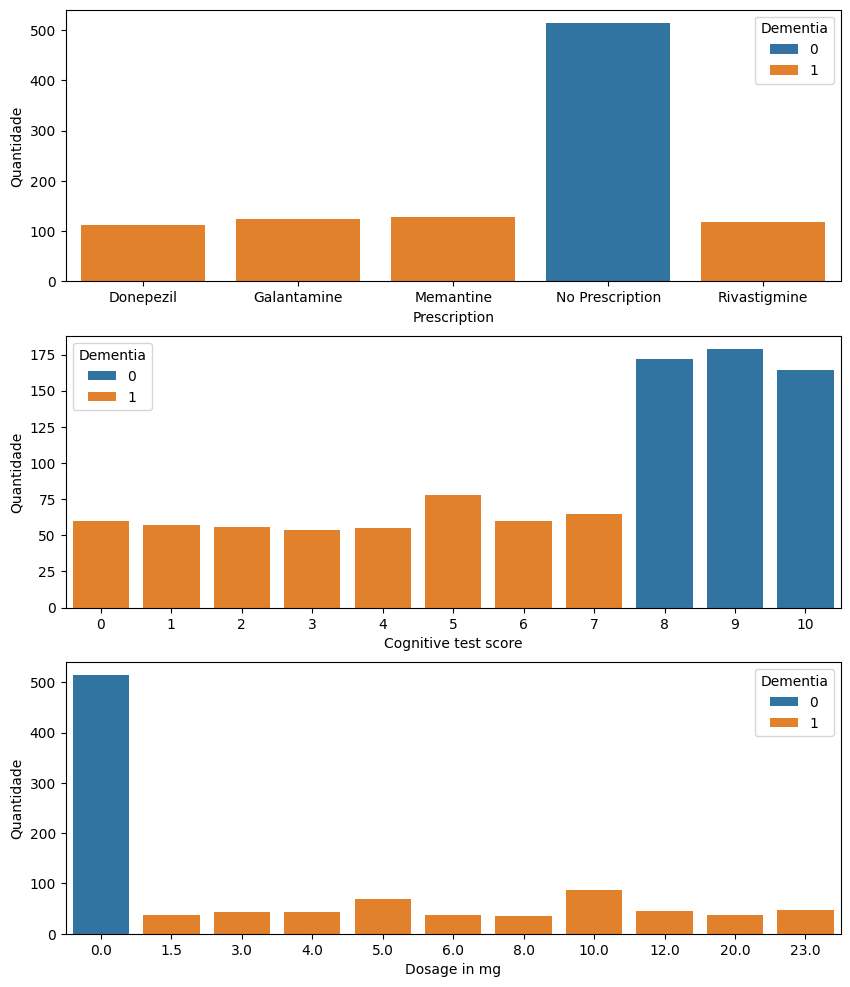

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
(ax1, ax2, ax3) = axs

sns.countplot(data=df, x='Prescription', hue='Dementia', ax=ax1)
ax1.set_ylabel('Quantidade')
ax1.set_xlabel('Prescription')

sns.countplot(data=df, x='Cognitive_Test_Scores', hue='Dementia', ax=ax2)
ax2.set_ylabel('Quantidade')
ax2.set_xlabel('Cognitive test score')

sns.countplot(data=df, x='Dosage in mg', hue='Dementia', ax=ax3)
ax3.set_ylabel('Quantidade')
ax3.set_xlabel('Dosage in mg')

plt.show()

#### Diabetic & Chronic_Health_Conditions

* A coluna 'Chronic_Health_Conditions' já engloba a informação da coluna 'Diabetic'. Sendo assim, deve-se remover a coluna 'Diabetic'.

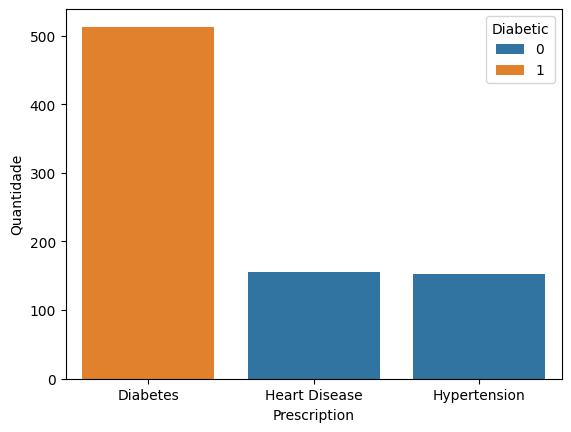

In [19]:
sns.countplot(data=df, x='Chronic_Health_Conditions', hue='Diabetic')
plt.ylabel('Quantidade')
plt.xlabel('Prescription')

plt.show()

#### APOE_ε4

* A coluna 'APOE_ε4' possui boa relação com o laudo de demência, sendo, provavelmente, um excelente dado para o desempenho da rede. Entretanto, visando o objetivo de que sejam utilizados dados de fácil coleta, essa coluna será removida. 

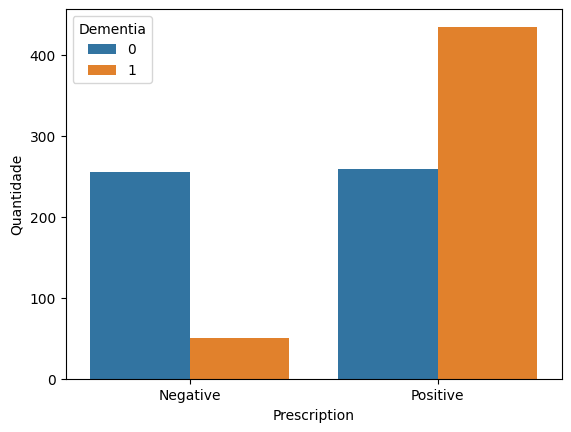

In [20]:
sns.countplot(data=df, x='APOE_ε4', hue='Dementia')
plt.ylabel('Quantidade')
plt.xlabel('Prescription')

plt.show()

## Data Analysis

In [21]:
encoder = LabelEncoder()

for column in df.columns:
  if df[column].dtypes == 'category':
    df[column] = encoder.fit_transform(df[column])

<Axes: >

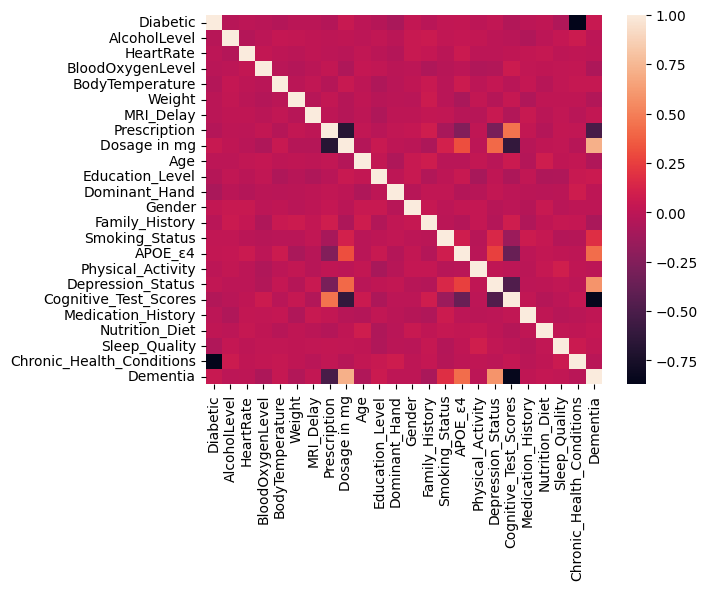

In [22]:
sns.heatmap(df.corr())

### Análise de balanceamento dos dados

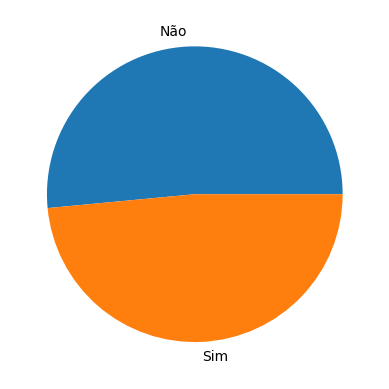

In [59]:
plt.pie(df.groupby(['Dementia']).Dementia.count().values, labels=['Não', 'Sim'])
plt.show()

## Training models

In [24]:
drop_columns = ['Diabetic', 'Prescription', 'Dosage in mg', 'Cognitive_Test_Scores', 'APOE_ε4']
df.drop(columns=drop_columns, inplace=True)

X = df.drop(columns=['Dementia'])
y = df['Dementia']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=SEED, stratify=y)

print(X_train.shape, y_train.shape)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

(700, 18) (700,)


In [26]:
class Scorer:
  acc = []
  prec = []
  rec = []
  f1 = []

  def scorer(self, model, x, y):
    pred = model.predict(x)
    self.acc.append(accuracy_score(y, pred))
    self.precision.append(precision_score(y, pred))
    self.recall.append(recall_score(y, pred))
    self.f1.append(f1_score(y, pred))

    return self.f1[-1]

  @ignore_warnings
  def cross_val_models(self, models):
    scores = {}
    for key in models:
      model = models[key]

      self.acc = []
      self.precision = []
      self.recall = []
      self.f1 = []

      print('----------------------', key, '----------------------')
      
      score = cross_val_score(model, X_train, y_train, scoring=self.scorer)
      scores[key] = np.mean(score)

      model.fit(X_train, y_train)
      pred = model.predict(X_test)
      fpr, tpr, thresh = roc_curve(y_test, pred)
      auc = roc_auc_score(y_test, pred)
      plt.plot(fpr,tpr,label=key + ": %.3f" % auc)

      print('Accuracy:', np.mean(self.acc))
      print('Precision:', np.mean(self.precision))
      print('Recall:', np.mean(self.recall))
      print('F1:', np.mean(self.f1))

    plt.legend(loc=0)
    plt.ylabel('Taxa de VP')
    plt.xlabel('Taxa de FP')

    return scores

---------------------- MLP ----------------------
Accuracy: 0.6985714285714286
Precision: 0.710636439583808
Recall: 0.6411764705882353
F1: 0.6734904574973847
---------------------- RF ----------------------
Accuracy: 0.7485714285714286
Precision: 0.8380841494146545
Recall: 0.6
F1: 0.6979463150630199
---------------------- SVC ----------------------
Accuracy: 0.7585714285714286
Precision: 0.9782786373173747
Recall: 0.5147058823529412
F1: 0.6732115225423374
---------------------- KNN 3 ----------------------


  File "c:\Users\phoso\miniconda3\envs\dscience\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Accuracy: 0.6885714285714286
Precision: 0.6986046652862955
Recall: 0.6323529411764706
F1: 0.6629778433819608
---------------------- KNN 5 ----------------------
Accuracy: 0.6957142857142857
Precision: 0.7224952301177348
Recall: 0.6058823529411764
F1: 0.6587011904761905
---------------------- KNN 7 ----------------------
Accuracy: 0.7142857142857143
Precision: 0.7510668290691044
Recall: 0.6176470588235293
F1: 0.6772658034407587
---------------------- GNB ----------------------
Accuracy: 0.7542857142857142
Precision: 1.0
Recall: 0.49411764705882355
F1: 0.6597167226204518
---------------------- SGD ----------------------
Accuracy: 0.7314285714285714
Precision: 0.8812000555902995
Recall: 0.5323529411764706
F1: 0.6542013116134273
---------------------- XGB ----------------------
Accuracy: 0.7271428571428572
Precision: 0.7509658706798537
Recall: 0.6558823529411765
F1: 0.6992122853120849


{'MLP': 0.6734904574973847,
 'RF': 0.6979463150630199,
 'SVC': 0.6732115225423374,
 'KNN 3': 0.6629778433819608,
 'KNN 5': 0.6587011904761905,
 'KNN 7': 0.6772658034407587,
 'GNB': 0.6597167226204518,
 'SGD': 0.6542013116134273,
 'XGB': 0.6992122853120849}

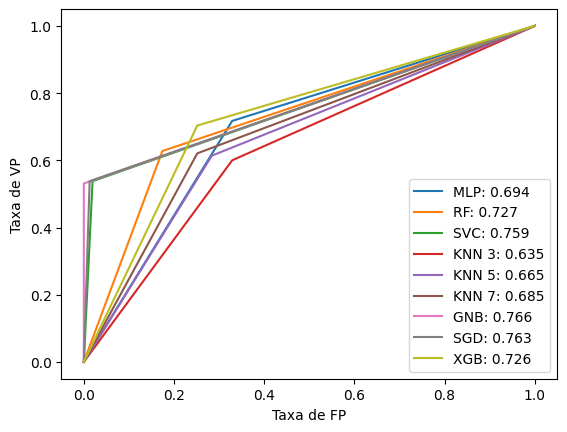

In [27]:
models = {
    'MLP': MLPClassifier(random_state=SEED, max_iter=600),
    'RF': RandomForestClassifier(n_estimators=100, random_state=SEED),
    'SVC': SVC(random_state=SEED),
    'KNN 3': KNeighborsClassifier(n_neighbors = 3),
    'KNN 5': KNeighborsClassifier(n_neighbors = 5),
    'KNN 7': KNeighborsClassifier(n_neighbors = 7),
    'GNB': GaussianNB(),
    'SGD': SGDClassifier(random_state=SEED),
    'XGB': xgb.XGBClassifier(tree_method="hist", random_state=SEED)
}

scorer = Scorer()
scorer.cross_val_models(models)

Acurácia:  72.66666666666667 %
Precision:  72.3404255319149 %
Recall:  70.34482758620689 %
F1:  0.7132867132867133


Text(0, 0.5, 'Recall')

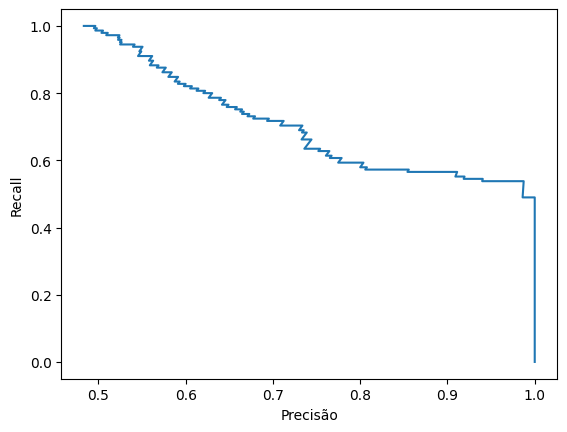

In [28]:
model = models['XGB']
model.fit(X_train, y_train)

predicts = model.predict(X_test)

print('Acurácia: ', accuracy_score(y_test, predicts) * 100, '%')
print('Precision: ', precision_score(y_test, predicts) * 100, '%')
print('Recall: ', recall_score(y_test, predicts) * 100, '%')
print('F1: ', f1_score(y_test, predicts))

precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(precision, recall)
plt.xlabel('Precisão')
plt.ylabel('Recall')

In [29]:
predicts = (model.predict_proba(X_test)[:,1] > .3).astype(bool)

print('Acurácia: ', accuracy_score(y_test, predicts) * 100, '%')
print('Precision: ', precision_score(y_test, predicts) * 100, '%')
print('Recall: ', recall_score(y_test, predicts) * 100, '%')
print('F1: ', f1_score(y_test, predicts))

Acurácia:  67.33333333333333 %
Precision:  62.98342541436463 %
Recall:  78.62068965517241 %
F1:  0.6993865030674846
